Get data from web and convert to dataframe

['hdf5', 'stage_data', 'raw_data']
total 12
drwxr-xr-x 2 jovyan users 4096 Feb 12 20:34 hdf5
drwxr-xr-x 2 jovyan users 4096 Feb 12 20:34 raw_data
drwxr-xr-x 2 jovyan users 4096 Feb 12 20:34 stage_data


,Symbol,Meaning,arrythmia,signal,artifact,other
0,N,Normal beat,False,False,False,False
1,L,Left bundle branch block beat,False,False,False,False
2,R,Right bundle branch block beat,False,False,False,False
3,A,Atrial premature beat,False,False,False,False
4,a,Aberrated atrial premature beat,False,False,False,False
5,J,Nodal (junctional) premature beat,False,False,False,False
6,S,Supraventricular premature beat,False,False,False,False
7,V,Premature ventricular contraction,False,False,False,True
8,F,Fusion of ventricular and normal beat,False,False,True,False
9,[,Start of ventricular flutter/fibrillation,True,False,False,False


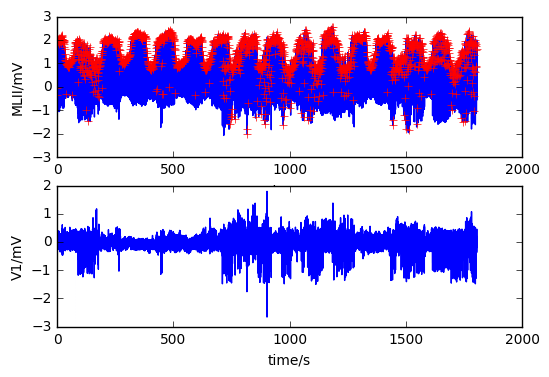

['mitdb.100.csv',
 'mitdb.101.csv',
 'mitdb.102.csv',
 'mitdb.103.csv',
 'mitdb.104.csv',
 'mitdb.105.csv',
 'mitdb.106.csv',
 'mitdb.107.csv',
 'mitdb.108.csv',
 'mitdb.109.csv',
 'mitdb.111.csv',
 'mitdb.112.csv',
 'mitdb.113.csv',
 'mitdb.114.csv',
 'mitdb.115.csv',
 'mitdb.116.csv',
 'mitdb.117.csv',
 'mitdb.118.csv',
 'mitdb.119.csv',
 'mitdb.121.csv',
 'mitdb.122.csv',
 'mitdb.123.csv',
 'mitdb.124.csv',
 'mitdb.200.csv',
 'mitdb.201.csv',
 'mitdb.202.csv',
 'mitdb.203.csv',
 'mitdb.205.csv',
 'mitdb.207.csv',
 'mitdb.208.csv',
 'mitdb.209.csv',
 'mitdb.210.csv',
 'mitdb.212.csv',
 'mitdb.213.csv',
 'mitdb.214.csv',
 'mitdb.215.csv',
 'mitdb.217.csv',
 'mitdb.219.csv',
 'mitdb.220.csv',
 'mitdb.221.csv',
 'mitdb.222.csv',
 'mitdb.223.csv',
 'mitdb.228.csv',
 'mitdb.230.csv',
 'mitdb.231.csv',
 'mitdb.232.csv',
 'mitdb.233.csv',
 'mitdb.234.csv',
 'mitdb.ann.100.txt',
 'mitdb.ann.101.txt',
 'mitdb.ann.102.txt',
 'mitdb.ann.103.txt',
 'mitdb.ann.104.txt',
 'mitdb.ann.105.txt',
 'mi

mitdb.100.csv


["'Elapsed time','MLII','V5'\n",
 "'hh:mm:ss.mmm','mV','mV'\n",
 "'0:00.000',-0.145,-0.065\n",
 "'0:00.003',-0.145,-0.065\n",
 "'0:00.006',-0.145,-0.065\n",
 "'0:00.008',-0.145,-0.065\n",
 "'0:00.011',-0.145,-0.065\n",
 "'0:00.014',-0.145,-0.065\n",
 "'0:00.017',-0.145,-0.065\n",
 "'0:00.019',-0.145,-0.065\n"]

<class 'pandas.io.pytables.HDFStore'>
File path: data/hdf5/mit-bih.hdf
/Annotation_Metadata            frame        (shape->[40,6])     
/Import_checksums               frame        (shape->[1,2])      
/Record_100                     frame        (shape->[649998,10])
/Record_101                     frame        (shape->[649998,10])
/Record_102                     frame        (shape->[649998,10])
/Record_103                     frame        (shape->[649998,10])
/Record_104                     frame        (shape->[649998,10])
/Record_105                     frame        (shape->[649998,10])
/Record_106                     frame        (shape->[649998,10])
/Record_107                     frame        (shape->[649998,10])
/Record_108                     frame        (shape->[649998,10])
/Record_109                     frame        (shape->[649998,10])
/Record_111                     frame        (shape->[649998,10])
/Record_112                     frame        (shape->[649998,10])
/Reco

,MLII_milliVolts,V5_milliVolts,Sample_num,Type,Sub,Chan,Num,Aux,arrythmia_events,normal_events
Elapsed_Microseconds,,,,,,,,,,
00:00:00.006000,-0.145,-0.065,NaN,NaN,NaN,NaN,NaN,NaN,0,0
00:00:00.008000,-0.145,-0.065,NaN,NaN,NaN,NaN,NaN,NaN,0,0
00:00:00.011000,-0.145,-0.065,NaN,NaN,NaN,NaN,NaN,NaN,0,0
00:00:00.014000,-0.145,-0.065,NaN,NaN,NaN,NaN,NaN,NaN,0,0
00:00:00.017000,-0.145,-0.065,NaN,NaN,NaN,NaN,NaN,NaN,0,0
00:00:00.019000,-0.145,-0.065,NaN,NaN,NaN,NaN,NaN,NaN,0,0
00:00:00.022000,-0.120,-0.080,NaN,NaN,NaN,NaN,NaN,NaN,0,0
00:00:00.025000,-0.135,-0.080,NaN,NaN,NaN,NaN,NaN,NaN,0,0
00:00:00.028000,-0.145,-0.085,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [1]:
%run "cog-web-to-dataframe.ipynb"

Install python tables (for pandas)

!pip3 install tables

Define Data Imports

In [2]:
import pandas as pd
import os
import re
from datetime import datetime
import numpy as np


hdf_filename = 'data/hdf5/mit-bih.hdf'

import matplotlib.pylab as pylab
import numpy
from matplotlib.widgets import Button

import wfdb

record_path = "\data\raw_datab\100"
record  =wfdb.Record(record_path)


start_time = 27                              # beginning position in seconds
time = 4                                     # data length in seconds
sample_length = int(time * record.frequency) # data length in sample units
end_time = start_time + time                 # end position in seconds

signals_num = record.nsig                    # number of signals in record

# default annotation file has .atr extension
default_ann = record.annotation()

## read all annotations for given range
annotations = default_ann.read(int(start_time*record.frequency), sample_length)

## drawing stuff follows
ylims = (-1.5, 1.5)
t = numpy.arrayrange(start_time, end_time, 1/record.frequency)
vl = numpy.arange(start_time, end_time, 0.2)
hl = numpy.arange(ylims[0], ylims[1], 0.5)

f = pylab.figure()
f.subplots_adjust(hspace=0.00001)

axes = []
ax = pylab.subplot(signals_num, 1, 1)
pylab.title('ECG record %s' % record.name)

annotation_lines = [ann.time/record.frequency for ann in annotations]

def mark_annotations(ax):
    annotation_font = {'family':'monospace', 'color':'b',
                           'weight':'bolder', 'size':12}
    for ann in annotations:
        ax.text(ann.time/record.frequency, ylims[1]-0.2, ann.typestr,
                        annotation_font, horizontalalignment='center')
    ax.vlines(annotation_lines, 0.8*ylims[0], 0.8*ylims[1], linewidth=.5,
                  fmt='b-', alpha=0.8)

for i, name in enumerate(record.signal_names):
    ax = pylab.subplot(signals_num, 1, i+1)
    axes.append(ax)

    pylab.ylabel('voltage (%s)' % record.signal_info(name)["units"])

    # draw pink grid
    ax.vlines(vl, ylims[0], ylims[1], fmt='r-', alpha=0.3)
    ax.hlines(hl, start_time, end_time, fmt='r-', alpha=0.3)

    # read data for specified signal
    # equal to record.read(i, ...
    y = record.read(name, int(start_time*record.frequency), sample_length)

    # draw signal
    ax.plot(t, y, linewidth=1, color='k', alpha=1.0, label=name)
    ax.text(start_time + 1.01*time , 1.2, name, color='k' )

    mark_annotations(ax)

    pylab.ylim(-1.5, 1.5)
    pylab.xlim(start_time, end_time)

pylab.xlabel('time (s)')
xticklabels = [a.get_xticklabels() for a in axes[:-1]]
pylab.setp(xticklabels, visible=False)

pylab.savefig('ecg_plot.png')
pylab.show()

In [3]:

def generate_normal_and_arrythmia_samples(anECGDataFrame, anOffsetWindow=[5000, 5000]):
    '''

    Args:
        anECGDataFrame : mitdb data
        anOffsetWindow

    Returns:
        DataFrame containing features for 
    '''
    def generate_time_interval(aFormatString=None, hours=0, minutes=0, seconds=0, microseconds=0):
        '''
        Args:
            aFormatString
            hours 			: number of hours
            minutes 		: number of minutes
            seconds 		: number of seconds
            mmicroseconds 	: number of mmicroseconds

        Returns:
            time intevrval
        '''
        if not aFormatString:
            aFormatString = ':'.join(map(str, [hours, minutes, seconds])) + '.' + str(microseconds)

        return datetime.strptime(aFormatString, '%H:%M:%S.%f') - datetime.strptime('0:0:0.0', '%H:%M:%S.%f')
    def generate_sample_intervals(aDataFrame, aTimeIndex, aLabel, aStartInterval, anEndInterval,
                                  aColumnList):
        '''
        Args:
            aDataFrame : time series data
            aTimeIndex : index of events in data
            aLabel : class to associate with these events
            aStartInterval : how far back to go 

        Returns:
            DataFrame
        '''
        def max_amplitude_filter(aSingleChannel):
            '''
            Args:
                aSingleChannel  :	  DataFrame

            Returns:
                filtered (list): temporal list of filtered values, peaks accentuated
            '''
            #modeFit = pd.rolling_kurt(aSingleChannel, 100)
            modeFit = aSingleChannel.rolling(window=100,center=False).kurt()
            #stdDev = pd.rolling_std(aSingleChannel - pd.rolling_mean(aSingleChannel, 10), 10)
            stdDev = (aSingleChannel - aSingleChannel.rolling(window=10,center=False).mean()).rolling(window=10,center=False).std()
            
            
            return aSingleChannel * modeFit * stdDev

        # for each event, generate an interval around it
        startIntervalList = aTimeIndex - aStartInterval
        endIntervalList = aTimeIndex + anEndInterval

        intervals = list(zip(startIntervalList, endIntervalList))
        sampleIntervals = []

        # for each event interval, save off series data and also features
        for start, end in intervals[1:]:

            # all mV values in a single series
            intervalSamples = aDataFrame.loc[start:end, aColumnList]
            intervalSeries = pd.Series(intervalSamples.as_matrix().ravel())

            # enhance features in each lead series
            # save off the max and var
            for signalName in aColumnList:
                #lead_filtered = max_amplitude_filter(intervalSamples[signalName])
                lead_filtered = max_amplitude_filter(signalName)
                intervalSeries[signalName + '_max'] = lead_filtered.max()
                intervalSeries[signalName + '_var'] = lead_filtered.var()

            intervalSeries['labels'] = aLabel

            sampleIntervals.append(intervalSeries)

        return pd.DataFrame(sampleIntervals)


    windowStartOffset = anOffsetWindow[0]
    windowEndOffset = anOffsetWindow[1]
    startInterval = generate_time_interval(microseconds=windowStartOffset)
    endInterval = generate_time_interval(microseconds=windowEndOffset)

    normalIndex = anECGDataFrame[anECGDataFrame.normal_events == 1].index
    arrythmiaIndex = anECGDataFrame[anECGDataFrame.arrythmia_events == 1].index

    leadNames = ['MLII_milliVolts', 'V5_milliVolts']
    normalFeatures    = generate_sample_intervals(anECGDataFrame, normalIndex, 0, startInterval, endInterval, leadNames)
    arrythmiaFeatures = generate_sample_intervals(anECGDataFrame, arrythmiaIndex, 1, startInterval, endInterval, leadNames)

    # combine data frames
    if arrythmiaFeatures.shape[0] > 0:
        normalFeatures = pd.concat([normalFeatures, arrythmiaFeatures])

    return normalFeatures

def generate_all_sample_record_intervals(anEcgDataFrame, anEqualSampling=True):
    '''
    grab records from HDS5 Datastore, process into huge set of feature vectors

    Args:
        anEcgDataFrame : mitDB data
        anEqualSampling : make equal number of each class

    Returns:
        DataFrame
    '''

    # get a list of all the recordings
    ecgFilter = filter(lambda x: re.search('Record_', x), anEcgDataFrame.keys())
    #ecgDataFrames = [anEcgDataFrame[k] for k in ecgFilter]  # replace with equery

    # generate all the sample data intervals for each record that has arrythmias
    # each record will have time around each annotated event
    # also, derived features are around each event
    mlStage = pd.DataFrame()
    firstTime=True;
    for ecgKey in ecgFilter:
        record = anEcgDataFrame[ecgKey]
        if record.arrythmia_events.sum() > 1:
            if len(record[record.arrythmia_events == 1].index) == 0:
                continue

            recordSamples = generate_normal_and_arrythmia_samples(record)
            if firstTime: 
              print(recordSamples)
              firstTime = False;
            mlStage = pd.concat([mlStage, recordSamples])

    mlStage.reset_index(drop=True, inplace=True)

    if len(mlStage.index) == 0:
        print("no arrythmia records, nothing to learn...")
        return

    ''' Reduce the number of normal samples to match the number of arrithmia samples
    '''
    if anEqualSampling:
        mask = mlStage['labels'] == 1  # 1 = arrythmia
        size = mlStage[mask].shape[0]  # total arrythmias
        randNormIndex = np.random.choice(mlStage[~mask].index, size)  # grab random normal
        index = np.concatenate([randNormIndex, mlStage[mask].index])  # 
        mlStage = mlStage.ix[index]
        mlStage.reset_index(drop=True, inplace=True)

    return mlStage

Create cached dataset if it doesn't exist, otherwise process it.

In [4]:
def extract_and_stage_ml(hdf_filename, anEqualSampling=True, useCached=True):
    '''
    Query the file for the arrythmia data, bring in normal data too

    Args:https://ubuntu:8888/notebooks/cog_wfdb-dataframe-to-cache.ipynb#
        anEcgDataFrame		: data frame
        anEqualSampling		: equalize the amount of each class

    Returns:
        DataFrame
    '''
    cache = 'cached_eq_ml_data.hdf'
    if useCached and os.path.isfile(cache):
        print('Using cached ML data...')
        equalized_data = pd.read_hdf(cache, 'cached_data')
    else:
        ecgDataframe = pd.HDFStore(hdf_filename)
        equalized_data = generate_all_sample_record_intervals(ecgDataframe)
        if (useCached):
            print('Creating cached ML data...')
            equalized_data.to_hdf(cache, 'cached_data')

    return equalized_data

samples = extract_and_stage_ml(hdf_filename, anEqualSampling=True, useCached=False)


#print(samples)
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


def plotter(row):
    plt.figure(figsize=(10, 5))
    plt.plot(row)
    plt.show()

print(samples.iloc[:,:])

samples.iloc[:4,:721].apply(lambda x: plotter(x), axis=1 ) 


f, axs = plt.subplots(4, sharex=True, sharey=True,figsize=(15, 20))
for rowIdx in range( len(axs) ):
    axs[rowIdx].plot( samples.iloc[rowIdx,:721] )
f.subplots_adjust(hspace=0)
    



AttributeError: 'str' object has no attribute 'rolling'